# Chapter 9: CycleGAN

# Imports

In [91]:
import torch
import torch.nn as nn
import torch.cuda as cuda
from torch.optim import Adam
from torchvision.datasets import VisionDataset, ImageFolder
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
from torchvision.transforms import Compose, ToTensor, Resize, Lambda
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [92]:
BATCH_SIZE = 32

# Loading data

PyTorch or torchvision does not come with the `apple2orange` dataset. Therefore we implement a full dataset which retrieves the data.

In [93]:
class Apple2Orange(VisionDataset):
    url = "https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip"
    base_folder = "apple2orange"
    filename = "apple2orange.zip"
    zip_md5 = "5b58c340256288622a835d6f3b6198ae"
    
    def __init__(self, root, train=True, transform=None, target_transform=None,
             download=False):
        super().__init__(root, transform=transform,
                            target_transform=target_transform)
        self.train = train
        self.train_folder = os.path.join(self.root, self.base_folder, "train")
        self.test_folder = os.path.join(self.root, self.base_folder, "test")

        if download:
            self.download()
            
        if train:
            root = self.train_folder
        else:
            root = self.test_folder
            
        self.apples = [f for f in os.scandir(os.path.join(root, "apple")) if f.is_file()]
        self.oranges = [f for f in os.scandir(os.path.join(root, "orange")) if f.is_file()]
        
    def __getitem__(self, index):
        return self.transform(default_loader(self.apples[index])), self.transform(default_loader(self.oranges[index]))
    
    def __len__(self):
        return min(len(self.apples), len(self.oranges))
            
    def _check_integrity(self):
        fpath = os.path.join(self.root, self.filename)
        
        if check_integrity(fpath, self.zip_md5) and os.path.exists(os.path.join(self.root, self.base_folder)):
            return True
        else:
            return False
        
            
    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        
        #download_and_extract_archive(self.url, self.root, filename=self.filename, md5=self.zip_md5)
        
        train_path = os.path.join(self.root, self.base_folder, "train")
        test_path = os.path.join(self.root, self.base_folder, "test")
        source_train_a = os.path.join(self.root, self.base_folder, "trainA")
        source_train_b = os.path.join(self.root, self.base_folder, "trainB")
        source_test_a = os.path.join(self.root, self.base_folder, "testA")
        source_test_b = os.path.join(self.root, self.base_folder, "testB")
        
        os.mkdir(train_path)
        os.mkdir(test_path)
        
        os.renames(source_train_a, os.path.join(train_path, "apple"))
        os.renames(source_train_b, os.path.join(train_path, "orange"))
        os.renames(source_test_a, os.path.join(test_path, "apple"))
        os.renames(source_test_b, os.path.join(test_path, "orange"))


In [94]:
t = Compose([Resize(128), ToTensor(), Lambda(lambda x: x * 2 - 1)])
train_set = Apple2Orange('~/pytorch', train=True, download=True, transform=t)
test_set = Apple2Orange('~/pytorch', train=False, download=True, transform=t)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


# Support CUDA

In [95]:
if cuda.is_available():
    print("Using cuda device for training")
    device = 'cuda'
else:
    print("Using cpu for training")
    device = 'cpu'

Using cuda device for training


# Generator

In [96]:
class Generator(nn.Module):
    class TransSkip(nn.Module):
        def __init__(self, in_channel, out_channel, kernel_size):
            super().__init__()
            self.trans1 = nn.Sequential(
                nn.UpsamplingBilinear2d(scale_factor=2),
                nn.Conv2d(in_channel, out_channel, kernel_size, stride=1, padding=int(kernel_size/2)),
                nn.LeakyReLU(negative_slope=0.2),
                nn.InstanceNorm2d(out_channel, affine=True))
            
        def forward(self, x, skip):
            trans = self.trans1(x)
            x = torch.cat([trans,  skip], dim=1)
            
            return x

    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_layer(3, 32, 3)
        self.conv2 = self.conv_layer(32, 64, 3)
        self.conv3 = self.conv_layer(64, 128, 3)
        self.conv4 = self.conv_layer(128, 256, 3)
        
        self.trans1 = self.TransSkip(256, 128, 3)
        self.trans2 = self.TransSkip(256, 64, 3)
        self.trans3 = self.TransSkip(128, 32, 3)
        # Check if using skip from first image improves result
        # self.trans4 = self.TransSkip(64, 64, 3)
        # self.conv5 = nn.Sequential(
        #     nn.Conv2d(67, 3, 3, stride=1, padding=1),
        #     nn.Tanh())
        self.trans4 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh())
    
    def forward(self, x):
        skip_0 = x
        skip_1 = x = self.conv1(x)
        skip_2 = x = self.conv2(x)
        skip_3 = x = self.conv3(x)
        x = self.conv4(x)
        x = self.trans1(x, skip_3)
        x = self.trans2(x, skip_2)
        x = self.trans3(x, skip_1)
        # x = self.trans4(x, skip_0)
        x = self.trans4(x)
        x = self.conv5(x)
        
        return x
    
    def conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.InstanceNorm2d(out_channels, affine=True))

In [97]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_layer(3, 64, 3)
        self.conv2 = self.conv_layer(64, 128, 3)
        self.conv3 = self.conv_layer(128, 256, 3)
        self.conv4 = self.conv_layer(256, 512, 3)
        self.conv5 = nn.Conv2d(512, 1, 4, stride=1, padding=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        return x
    
    def conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=int(kernel_size/2)),
            nn.LeakyReLU(negative_slope=0.2),
            nn.InstanceNorm2d(out_channels, affine=True))

In [98]:
gen_AB = Generator().to(device)
gen_BA = Generator().to(device)
dis_A = Discriminator().to(device)
dis_B = Discriminator().to(device)

cycle_loss_criteria = nn.L1Loss()
adversarial_loss_criteria = nn.MSELoss()

real = torch.ones(BATCH_SIZE, 1, 9, 9).to(device)
fake = torch.zeros(BATCH_SIZE, 1, 9, 9).to(device)

dis_A_optim = Adam(dis_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
dis_B_optim = Adam(dis_B.parameters(), lr=0.0002, betas=(0.5, 0.999))
gen_AB_optim = Adam(gen_AB.parameters(), lr=0.0002, betas=(0.5, 0.999))
gen_BA_optim = Adam(gen_BA.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [99]:
for epoch in range(100):
    for img_A, img_B in tqdm(train_loader):
        img_A = img_A.to(device)
        img_B = img_B.to(device)
        # A -> B
        img_B_gen = gen_AB(img_A)
        d_out = dis_B(img_B_gen)
        fake_loss = adversarial_loss_criteria(d_out, fake)

        dis_B_optim.zero_grad()
        fake_loss.backward()
        dis_B_optim.step()

        d_out = dis_B(img_B)
        real_loss = adversarial_loss_criteria(d_out, real)
        
        total_disA_loss = fake_loss + real_loss

        dis_B_optim.zero_grad()
        real_loss.backward()
        dis_B_optim.step()

        # B -> A
        img_A_gen = gen_BA(img_A)
        d_out = dis_A(img_A_gen)
        fake_loss = adversarial_loss_criteria(d_out, fake)

        dis_A_optim.zero_grad()
        fake_loss.backward()
        dis_A_optim.step()

        d_out = dis_A(img_A)
        fake_loss = adversarial_loss_criteria(d_out, real)
        
        total_disB_loss = fake_loss + real_loss

        dis_A_optim.zero_grad()
        fake_loss.backward()
        dis_A_optim.step()

        # Generator
        img_B_gen = gen_AB(img_A)
        img_A_rec = gen_BA(img_B_gen)
        d_out = dis_B(img_B_gen)
        img_B_gen2 = gen_AB(img_B)

        rec_A_loss = cycle_loss_criteria(img_A, img_A_rec) #* 10
        adv_A_loss = adversarial_loss_criteria(d_out, real)
        id_A_loss = cycle_loss_criteria(img_B, img_B_gen2) #* 9
        total_A_loss = rec_A_loss + adv_A_loss + id_A_loss

        img_A_gen = gen_BA(img_B)
        img_B_rec = gen_AB(img_A_gen)
        d_out = dis_A(img_A_gen)
        img_A_gen2 = gen_BA(img_A)

        rec_B_loss = cycle_loss_criteria(img_B, img_B_rec) #* 10
        adv_B_loss = adversarial_loss_criteria(d_out, real)
        id_B_loss = cycle_loss_criteria(img_A, img_A_gen2) #* 9
        total_B_loss = rec_B_loss + adv_B_loss + id_B_loss

        gen_AB_optim.zero_grad()
        gen_BA_optim.zero_grad()

        total_A_loss.backward()
        total_B_loss.backward()

        gen_AB_optim.step()
        gen_BA_optim.step()

    print(f"Epoch: {epoch} A_total: {total_A_loss:.4f} A_dis_fake: {adv_A_loss:.4f} A_dis_real: {total_disA_loss:.4f}")
    print(f"Epoch: {epoch} B_total: {total_B_loss:.4f} B_dis_fake: {adv_B_loss:.4f} B_dis_real: {total_disB_loss:.4f}")


Epoch: 0 A_total: 7.3136 A_dis_fake: 0.6984 A_dis_real: 0.3790
Epoch: 0 B_total: 7.2365 B_dis_fake: 0.5994 B_dis_real: 0.5562



Epoch: 1 A_total: 7.5212 A_dis_fake: 0.7425 A_dis_real: 0.3432
Epoch: 1 B_total: 7.5364 B_dis_fake: 0.6847 B_dis_real: 0.5616



Epoch: 2 A_total: 6.0841 A_dis_fake: 0.7156 A_dis_real: 0.3178
Epoch: 2 B_total: 5.9524 B_dis_fake: 0.5840 B_dis_real: 0.4174



Epoch: 3 A_total: 6.0559 A_dis_fake: 0.7868 A_dis_real: 0.2657
Epoch: 3 B_total: 5.8687 B_dis_fake: 0.6523 B_dis_real: 0.3856



Epoch: 4 A_total: 5.5429 A_dis_fake: 0.8024 A_dis_real: 0.2170
Epoch: 4 B_total: 5.4966 B_dis_fake: 0.6578 B_dis_real: 0.3137



Epoch: 5 A_total: 5.6930 A_dis_fake: 0.7651 A_dis_real: 0.2016
Epoch: 5 B_total: 5.3818 B_dis_fake: 0.5839 B_dis_real: 0.3056



Epoch: 6 A_total: 5.0005 A_dis_fake: 0.8709 A_dis_real: 0.1689
Epoch: 6 B_total: 4.7892 B_dis_fake: 0.6165 B_dis_real: 0.2409



Epoch: 7 A_total: 5.4121 A_dis_fake: 0.8201 A_dis_real: 0.2509
Epoch: 7 B_total: 5.1705 B_dis_fake: 0.6950 B_dis_real: 0.3165



Epoch: 8 A_total: 4.6758 A_dis_fake: 0.7322 A_dis_real: 0.2236
Epoch: 8 B_total: 4.4769 B_dis_fake: 0.5967 B_dis_real: 0.4499



Epoch: 9 A_total: 5.0995 A_dis_fake: 0.8522 A_dis_real: 0.1370
Epoch: 9 B_total: 4.8084 B_dis_fake: 0.6023 B_dis_real: 0.3139



Epoch: 10 A_total: 4.9691 A_dis_fake: 0.9008 A_dis_real: 0.1282
Epoch: 10 B_total: 4.7680 B_dis_fake: 0.6446 B_dis_real: 0.1647



Epoch: 11 A_total: 4.9039 A_dis_fake: 0.8931 A_dis_real: 0.1508
Epoch: 11 B_total: 4.5355 B_dis_fake: 0.5865 B_dis_real: 0.2587



Epoch: 12 A_total: 5.0413 A_dis_fake: 0.9098 A_dis_real: 0.1485
Epoch: 12 B_total: 4.8854 B_dis_fake: 0.7241 B_dis_real: 0.2352



Epoch: 13 A_total: 4.7312 A_dis_fake: 0.7698 A_dis_real: 0.1398
Epoch: 13 B_total: 4.4946 B_dis_fake: 0.5308 B_dis_real: 0.1921



Epoch: 14 A_total: 4.5850 A_dis_fake: 0.8949 A_dis_real: 0.1422
Epoch: 14 B_total: 4.4057 B_dis_fake: 0.6776 B_dis_real: 0.2604



Epoch: 15 A_total: 4.8914 A_dis_fake: 1.0929 A_dis_real: 0.1389
Epoch: 15 B_total: 4.4760 B_dis_fake: 0.6543 B_dis_real: 0.1660



Epoch: 16 A_total: 4.5466 A_dis_fake: 0.9832 A_dis_real: 0.1906
Epoch: 16 B_total: 4.2318 B_dis_fake: 0.7147 B_dis_real: 0.1789



Epoch: 17 A_total: 4.6257 A_dis_fake: 0.9154 A_dis_real: 0.2493
Epoch: 17 B_total: 4.3191 B_dis_fake: 0.6223 B_dis_real: 0.2223



Epoch: 18 A_total: 4.5120 A_dis_fake: 0.9950 A_dis_real: 0.1087
Epoch: 18 B_total: 4.1517 B_dis_fake: 0.6738 B_dis_real: 0.1160



Epoch: 19 A_total: 4.5268 A_dis_fake: 0.9555 A_dis_real: 0.1027
Epoch: 19 B_total: 4.2995 B_dis_fake: 0.6922 B_dis_real: 0.1346



Epoch: 20 A_total: 4.2532 A_dis_fake: 0.9152 A_dis_real: 0.0629
Epoch: 20 B_total: 4.0828 B_dis_fake: 0.7014 B_dis_real: 0.0837



Epoch: 21 A_total: 4.5518 A_dis_fake: 1.0974 A_dis_real: 0.1024
Epoch: 21 B_total: 4.0807 B_dis_fake: 0.6725 B_dis_real: 0.0935



Epoch: 22 A_total: 4.2811 A_dis_fake: 0.9192 A_dis_real: 0.0877
Epoch: 22 B_total: 3.9521 B_dis_fake: 0.6130 B_dis_real: 0.1442



Epoch: 23 A_total: 4.8429 A_dis_fake: 0.9669 A_dis_real: 0.0607
Epoch: 23 B_total: 4.7735 B_dis_fake: 0.6772 B_dis_real: 0.0892



Epoch: 24 A_total: 4.5439 A_dis_fake: 0.9762 A_dis_real: 0.0781
Epoch: 24 B_total: 4.2810 B_dis_fake: 0.6673 B_dis_real: 0.0899



Epoch: 25 A_total: 4.1328 A_dis_fake: 0.9831 A_dis_real: 0.0571
Epoch: 25 B_total: 3.7617 B_dis_fake: 0.5194 B_dis_real: 0.1941



Epoch: 26 A_total: 4.2817 A_dis_fake: 0.9760 A_dis_real: 0.0677
Epoch: 26 B_total: 3.8899 B_dis_fake: 0.6177 B_dis_real: 0.1002



Epoch: 27 A_total: 3.9792 A_dis_fake: 0.8857 A_dis_real: 0.0678
Epoch: 27 B_total: 3.8255 B_dis_fake: 0.7356 B_dis_real: 0.0970



Epoch: 28 A_total: 4.1965 A_dis_fake: 0.9948 A_dis_real: 0.0643
Epoch: 28 B_total: 3.8696 B_dis_fake: 0.6923 B_dis_real: 0.1119



Epoch: 29 A_total: 4.3354 A_dis_fake: 0.9340 A_dis_real: 0.0449
Epoch: 29 B_total: 4.0914 B_dis_fake: 0.6507 B_dis_real: 0.0657



Epoch: 30 A_total: 4.2406 A_dis_fake: 0.9156 A_dis_real: 0.0550
Epoch: 30 B_total: 4.0468 B_dis_fake: 0.6685 B_dis_real: 0.0868



Epoch: 31 A_total: 4.0093 A_dis_fake: 0.9028 A_dis_real: 0.0587
Epoch: 31 B_total: 3.8013 B_dis_fake: 0.6792 B_dis_real: 0.0630



Epoch: 32 A_total: 3.9232 A_dis_fake: 1.0029 A_dis_real: 0.0824
Epoch: 32 B_total: 3.6830 B_dis_fake: 0.7013 B_dis_real: 0.0909



Epoch: 33 A_total: 4.0698 A_dis_fake: 0.9711 A_dis_real: 0.0983
Epoch: 33 B_total: 3.7334 B_dis_fake: 0.5741 B_dis_real: 0.1973



Epoch: 34 A_total: 3.7251 A_dis_fake: 0.8392 A_dis_real: 0.1064
Epoch: 34 B_total: 3.3929 B_dis_fake: 0.4773 B_dis_real: 0.1494



Epoch: 35 A_total: 4.4201 A_dis_fake: 1.0537 A_dis_real: 0.0742
Epoch: 35 B_total: 3.8416 B_dis_fake: 0.5225 B_dis_real: 0.0723



Epoch: 36 A_total: 3.9346 A_dis_fake: 0.9888 A_dis_real: 0.0256
Epoch: 36 B_total: 3.7622 B_dis_fake: 0.7008 B_dis_real: 0.0758



Epoch: 37 A_total: 4.2387 A_dis_fake: 1.0066 A_dis_real: 0.0275
Epoch: 37 B_total: 3.8702 B_dis_fake: 0.5750 B_dis_real: 0.0731



Epoch: 38 A_total: 3.9782 A_dis_fake: 1.0299 A_dis_real: 0.0765
Epoch: 38 B_total: 3.7688 B_dis_fake: 0.7519 B_dis_real: 0.1941



Epoch: 39 A_total: 3.8708 A_dis_fake: 0.9999 A_dis_real: 0.0285
Epoch: 39 B_total: 3.5760 B_dis_fake: 0.6190 B_dis_real: 0.0515



Epoch: 40 A_total: 3.8537 A_dis_fake: 0.9923 A_dis_real: 0.0339
Epoch: 40 B_total: 3.3507 B_dis_fake: 0.4945 B_dis_real: 0.0693



Epoch: 41 A_total: 3.7427 A_dis_fake: 0.9226 A_dis_real: 0.0928
Epoch: 41 B_total: 3.6897 B_dis_fake: 0.6998 B_dis_real: 0.0626



Epoch: 42 A_total: 3.8451 A_dis_fake: 0.9419 A_dis_real: 0.0320
Epoch: 42 B_total: 3.5342 B_dis_fake: 0.5731 B_dis_real: 0.0454



Epoch: 43 A_total: 3.8478 A_dis_fake: 0.9711 A_dis_real: 0.0208
Epoch: 43 B_total: 3.5366 B_dis_fake: 0.5813 B_dis_real: 0.0465



Epoch: 44 A_total: 3.7772 A_dis_fake: 0.9748 A_dis_real: 0.0293
Epoch: 44 B_total: 3.3216 B_dis_fake: 0.4709 B_dis_real: 0.0554



Epoch: 45 A_total: 3.9843 A_dis_fake: 1.0068 A_dis_real: 0.0194
Epoch: 45 B_total: 3.5800 B_dis_fake: 0.4994 B_dis_real: 0.0441



Epoch: 46 A_total: 3.8800 A_dis_fake: 0.9878 A_dis_real: 0.0378
Epoch: 46 B_total: 3.5459 B_dis_fake: 0.6396 B_dis_real: 0.0430



Epoch: 47 A_total: 3.5589 A_dis_fake: 1.0158 A_dis_real: 0.0352
Epoch: 47 B_total: 3.1732 B_dis_fake: 0.5159 B_dis_real: 0.0526



Epoch: 48 A_total: 3.7606 A_dis_fake: 0.9729 A_dis_real: 0.0450
Epoch: 48 B_total: 3.6738 B_dis_fake: 0.7342 B_dis_real: 0.0630



Epoch: 49 A_total: 3.8664 A_dis_fake: 0.9955 A_dis_real: 0.0207
Epoch: 49 B_total: 3.4784 B_dis_fake: 0.5301 B_dis_real: 0.0384



Epoch: 50 A_total: 3.6720 A_dis_fake: 0.9530 A_dis_real: 0.0251
Epoch: 50 B_total: 3.3781 B_dis_fake: 0.5871 B_dis_real: 0.0415



Epoch: 51 A_total: 3.8343 A_dis_fake: 0.9037 A_dis_real: 0.0425
Epoch: 51 B_total: 3.6292 B_dis_fake: 0.6563 B_dis_real: 0.0974



Epoch: 52 A_total: 3.9050 A_dis_fake: 1.0191 A_dis_real: 0.0339
Epoch: 52 B_total: 3.4266 B_dis_fake: 0.5350 B_dis_real: 0.0683



Epoch: 53 A_total: 3.9138 A_dis_fake: 0.9994 A_dis_real: 0.0227
Epoch: 53 B_total: 3.5458 B_dis_fake: 0.4573 B_dis_real: 0.0439



Epoch: 54 A_total: 3.5845 A_dis_fake: 1.0044 A_dis_real: 0.0180
Epoch: 54 B_total: 3.1450 B_dis_fake: 0.4265 B_dis_real: 0.0429



Epoch: 55 A_total: 3.7607 A_dis_fake: 0.9482 A_dis_real: 0.0286
Epoch: 55 B_total: 3.4005 B_dis_fake: 0.5178 B_dis_real: 0.0663



Epoch: 56 A_total: 3.5826 A_dis_fake: 0.9608 A_dis_real: 0.0311
Epoch: 56 B_total: 3.1580 B_dis_fake: 0.4871 B_dis_real: 0.0618



Epoch: 57 A_total: 3.6268 A_dis_fake: 0.9911 A_dis_real: 0.0218
Epoch: 57 B_total: 3.2784 B_dis_fake: 0.5726 B_dis_real: 0.0330



Epoch: 58 A_total: 3.5297 A_dis_fake: 1.0075 A_dis_real: 0.0198
Epoch: 58 B_total: 3.2215 B_dis_fake: 0.5218 B_dis_real: 0.0255



Epoch: 59 A_total: 3.4978 A_dis_fake: 1.0204 A_dis_real: 0.0297
Epoch: 59 B_total: 3.0098 B_dis_fake: 0.4652 B_dis_real: 0.0384



Epoch: 60 A_total: 3.7801 A_dis_fake: 1.0509 A_dis_real: 0.0679
Epoch: 60 B_total: 3.2019 B_dis_fake: 0.3733 B_dis_real: 0.0667



Epoch: 61 A_total: 4.0339 A_dis_fake: 0.9970 A_dis_real: 0.0154
Epoch: 61 B_total: 9.6275 B_dis_fake: 6.2994 B_dis_real: 3.1888



Epoch: 62 A_total: 3.5831 A_dis_fake: 1.0051 A_dis_real: 0.0358
Epoch: 62 B_total: 2.9307 B_dis_fake: 0.3217 B_dis_real: 0.3482



Epoch: 63 A_total: 3.2389 A_dis_fake: 0.6302 A_dis_real: 0.2924
Epoch: 63 B_total: 2.9022 B_dis_fake: 0.2982 B_dis_real: 0.5048



Epoch: 64 A_total: 3.3965 A_dis_fake: 0.9890 A_dis_real: 0.0401
Epoch: 64 B_total: 2.7671 B_dis_fake: 0.2961 B_dis_real: 0.3056



Epoch: 65 A_total: 3.5905 A_dis_fake: 0.9821 A_dis_real: 0.0176
Epoch: 65 B_total: 2.9100 B_dis_fake: 0.2957 B_dis_real: 0.2206



Epoch: 66 A_total: 3.5263 A_dis_fake: 1.0002 A_dis_real: 0.0317
Epoch: 66 B_total: 2.8022 B_dis_fake: 0.2863 B_dis_real: 0.2183



Epoch: 67 A_total: 3.5585 A_dis_fake: 0.9969 A_dis_real: 0.0155
Epoch: 67 B_total: 2.9042 B_dis_fake: 0.3209 B_dis_real: 0.1893


KeyboardInterrupt: 

In [111]:
real_A, real_B = train_set[1]
real_A = real_A.to(device)
real_B = real_B.to(device)
real_A = (real_A + 1) / 2
real_B = (real_B + 1) / 2

In [112]:
fake_B, fake_A = gen_AB(real_A.unsqueeze(dim=0)), gen_BA(real_B.unsqueeze(dim=0))
fake_A = (fake_A + 1) / 2
fake_B = (fake_B + 1) / 2

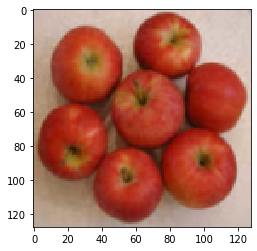

In [113]:
plt.imshow(real_A.to('cpu').permute(1,2,0))

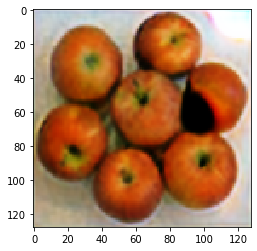

In [109]:
plt.imshow(fake_B.to('cpu').detach().squeeze().permute(1,2,0))

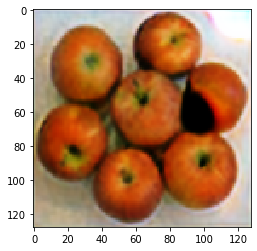

In [110]:
plt.imshow(fake_B.to('cpu').detach().squeeze().permute(1,2,0))

In [ ]:
fake_A.shape

In [ ]:
rec_A = gen_BA(fake_B)

In [ ]:
rec_A = (rec_A + 1) / 2

In [ ]:
plt.imshow(rec_A.to('cpu').detach().squeeze().permute(1,2,0))